# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install --upgrade pip seaborn

In [2]:

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
# kernel dies when loading large data
azdias = azdias.sample(n=200000, random_state=42)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
848815,956771,1,1.0,12.0,NaN,NaN,NaN,NaN,12.0,6.0,...,2.0,9.0,12.0,10.0,NaN,9.0,4.0,3,2,3
299816,536767,-1,1.0,0.0,NaN,NaN,NaN,NaN,21.0,1.0,...,1.0,2.0,3.0,3.0,3.0,8.0,3.0,1,2,2
570748,393990,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,8.0,9.0,6.0,6.0,9.0,7.0,1,1,1
354371,596074,-1,9.0,16.0,NaN,NaN,NaN,NaN,15.0,1.0,...,NaN,2.0,3.0,4.0,2.0,9.0,3.0,1,1,3
329018,586471,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3


In [5]:
# kernel dies when loading large data
customers = customers.sample(n=100000, random_state=42)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
182218,110819,1,1.0,12.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,3.0,9.0,2.0,2,COSMETIC,SINGLE_BUYER,0,1,3
147893,158648,3,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,1,COSMETIC,MULTI_BUYER,0,1,3
147678,155512,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,1
146951,177101,2,1.0,12.0,NaN,NaN,NaN,NaN,12.0,0.0,...,7.0,NaN,9.0,1.0,1,FOOD,MULTI_BUYER,0,2,4
169457,86805,1,1.0,18.0,NaN,NaN,NaN,NaN,12.0,2.0,...,2.0,2.0,9.0,2.0,1,FOOD,SINGLE_BUYER,0,1,4


In [6]:
CUSTOMER_GROUP = customers['CUSTOMER_GROUP'].unique()
ONLINE_PURCHASE = customers['ONLINE_PURCHASE'].unique()
PRODUCT_GROUP = customers['PRODUCT_GROUP'].unique()

print(CUSTOMER_GROUP)
print(ONLINE_PURCHASE)
print(PRODUCT_GROUP)

['SINGLE_BUYER' 'MULTI_BUYER']
[0 1]
['COSMETIC' 'COSMETIC_AND_FOOD' 'FOOD']


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [7]:
# Find unknown features in DIAS Attributes - Values 2017.xlsx

# Read the Excel file, specifying the range and including the 'Attribute', 'Meaning', and 'Value' columns
dias_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols='B:E', skiprows=1)

# Reset the index and rename the columns
dias_info = dias_info.reset_index(drop=True)
dias_info.columns = ['Attribute', 'Description', 'Value', 'Meaning']

# Drop rows with empty 'Attribute' values
# dias_info = dias_info.dropna(subset=['Attribute'])
dias_info['Attribute'].fillna(method='ffill', inplace=True)

# Print the number of rows remaining after dropping empty Attribute rows
# print(f"Number of rows after dropping empty Attribute values: {len(dias_info)}")

# Remove suffix '_RZ' from Attribute values
dias_info['Attribute'] = dias_info['Attribute'].str.replace('_RZ$', '', regex=True)

# Replace CAMEO_DEUINTL_2015 with CAMEO_INTL_2015 in the 'Attribute' column
dias_info.loc[dias_info['Attribute'] == 'CAMEO_DEUINTL_2015', 'Attribute'] = 'CAMEO_INTL_2015'

# KBA13_CCM_1400_2500 with KBA13_CCM_1401_2500
dias_info.loc[dias_info['Attribute'] == 'KBA13_CCM_1400_2500', 'Attribute'] = 'KBA13_CCM_1401_2500'

# SOHO_FLAG with SOHO_KZ
dias_info.loc[dias_info['Attribute'] == 'SOHO_FLAG', 'Attribute'] = 'SOHO_KZ'

# D19_KK_KUNDENTYP with KK_KUNDENTYP
dias_info.loc[dias_info['Attribute'] == 'D19_KK_KUNDENTYP', 'Attribute'] = 'KK_KUNDENTYP'

# D19_BUCH with D19_BUCH_CD
dias_info.loc[dias_info['Attribute'] == 'D19_BUCH', 'Attribute'] = 'D19_BUCH_CD'

# Reset the index after dropping rows
dias_info = dias_info.reset_index(drop=True)

# Drop the 'Description' column
dias_info = dias_info.drop('Description', axis=1)

# Find rows where 'Meaning' is unknown
unknown_rows = dias_info[dias_info['Meaning'].isin(['unknown', 'no transaction known', 'no transactions known'])].astype(str)

# Print the total number of unknown rows
print(f"\nTotal number of rows with unknown values: {len(unknown_rows)}")

# Filter rows where Value is -1, 0, or 9, 10
features_unknown_0 = unknown_rows[unknown_rows['Value'].str.contains('^0|, 0$', regex=True)].reset_index(drop=True)['Attribute'].tolist()
features_unknown_9 = unknown_rows[unknown_rows['Value'].str.contains('9')].reset_index(drop=True)['Attribute'].tolist()
features_unknown_10 = unknown_rows[unknown_rows['Value'].str.contains('10')].reset_index(drop=True)['Attribute'].tolist()



Total number of rows with unknown values: 288


In [8]:
attr_not_exist = set(dias_info['Attribute']) - set(azdias.columns)
not_explained_feature = set(azdias.columns) - set(dias_info['Attribute'])
print(f'{len(attr_not_exist)} attributes that do not exist in dataset features:\n{attr_not_exist}\n')
print(f'{len(not_explained_feature)} dataset features that are not explained in docs:\n{not_explained_feature}')

4 attributes that do not exist in dataset features:
{'BIP_FLAG', 'GEOSCORE_KLS7', 'WACHSTUMSGEBIET_NB', 'HAUSHALTSSTRUKTUR'}

56 dataset features that are not explained in docs:
{'ARBEIT', 'D19_LETZTER_KAUF_BRANCHE', 'ALTER_KIND4', 'CJT_TYP_3', 'RT_KEIN_ANREIZ', 'CJT_TYP_4', 'VHA', 'LNR', 'UMFELD_ALT', 'GEMEINDETYP', 'KBA13_HHZ', 'KONSUMZELLE', 'CJT_TYP_5', 'ALTER_KIND1', 'ANZ_KINDER', 'RT_SCHNAEPPCHEN', 'MOBI_RASTER', 'DSL_FLAG', 'D19_SOZIALES', 'ALTER_KIND3', 'EINGEFUEGT_AM', 'D19_VERSI_ONLINE_QUOTE_12', 'STRUKTURTYP', 'KBA13_ANTG1', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 'UNGLEICHENN_FLAG', 'VK_DHT4A', 'ALTERSKATEGORIE_FEIN', 'KBA13_ANTG4', 'VERDICHTUNGSRAUM', 'VHN', 'CJT_KATALOGNUTZER', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_VERSI_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'VK_ZG11', 'EXTSEL992', 'KBA13_BAUMAX', 'KBA13_ANTG3', 'EINGEZOGENAM_HH_JAHR', 'VK_DISTANZ', 'ALTER_KIND2', 'KBA13_KMH_210', 'UMFELD_JUNG', 'AKT_DAT_KL', 'CJT_TYP_2', 'D19_VERSI_ONLINE_DATUM', 'KBA13_ANTG2', 'D19_VERSI_OFFLINE_

In [9]:
# Check data types of the features
print(customers.dtypes.unique())
print(azdias.dtypes.unique())

[dtype('int64') dtype('float64') dtype('O')]
[dtype('int64') dtype('float64') dtype('O')]


In [10]:
for column in azdias.select_dtypes(include=['object']):
    print(f'Feature: {column}')
    print(azdias[column].unique())

Feature: CAMEO_DEU_2015
['9B' '4C' '3A' nan '9D' '2B' '8D' '4D' '1D' '2D' '2A' '7A' '5D' '8A' '9A'
 '7D' '3D' '6B' '3C' '4A' '8C' '5F' '6C' '7B' '3B' '9E' '4E' '5A' '4B'
 '7E' '5B' '5E' '1E' '1A' '8B' '9C' '2C' '5C' '1B' '7C' '6A' '6D' '6E'
 '1C' '6F' 'XX']
Feature: CAMEO_DEUG_2015
['9' 4.0 '4' 3.0 nan 9.0 '2' '8' 2.0 '1' '7' '5' 8.0 7.0 '3' '6' 6.0 5.0
 1.0 'X']
Feature: CAMEO_INTL_2015
['51' 24.0 '24' 23.0 nan 51.0 '13' '55' 13.0 '15' '14' '12' '41' '34' '52'
 54.0 '25' '43' 14.0 22.0 '54' '22' 12.0 '35' 43.0 '44' 44.0 '23' 55.0
 25.0 41.0 '31' 45.0 32.0 '45' 15.0 34.0 33.0 35.0 52.0 '32' 31.0 'XX'
 '33']
Feature: D19_LETZTER_KAUF_BRANCHE
['D19_UNBEKANNT' 'D19_BANKEN_DIREKT' nan 'D19_VERSICHERUNGEN'
 'D19_TELKO_REST' 'D19_SONSTIGE' 'D19_VOLLSORTIMENT' 'D19_BUCH_CD'
 'D19_VERSAND_REST' 'D19_DROGERIEARTIKEL' 'D19_BEKLEIDUNG_REST'
 'D19_SCHUHE' 'D19_BANKEN_LOKAL' 'D19_BEKLEIDUNG_GEH' 'D19_TECHNIK'
 'D19_WEIN_FEINKOST' 'D19_HAUS_DEKO' 'D19_TELKO_MOBILE' 'D19_FREIZEIT'
 'D19_RATGEBER' 'D1

In [11]:

def replace_special_data_with_nan(df, columns=None, special_value=-1):
    """
    Replace special values with NaN.
    
    :param df: pandas DataFrame
    :param columns: list of column names to process (optional)
    :param special_value: value to be replaced with NaN (default -1)
    :return: DataFrame with special values replaced with NaN
    """
    if columns is None:
        columns = df.columns
    
    for column in columns:
        
        if column in df.columns and df[column].dtype in ['int8', 'int32', 'int64', 'float32', 'float64']:
            
            # Replace special values with NaN
            df.loc[df[column] == special_value, column] = np.nan
    
    return df

def clean_data(df):
    
    # Replace 'XX' values with NaN
    columns_to_replace_XX = ['CAMEO_INTL_2015', 'CAMEO_DEU_2015']
    df.loc[:, columns_to_replace_XX] = df[columns_to_replace_XX].replace('XX', np.nan)
    
    # Replace 'X' values with NaN
    df.loc[:, 'CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    
    # Convert string value to float
    df.loc[:, 'CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float32')
    df.loc[:, 'CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('float32')
    
    # Convert to category codes
    df.loc[:, 'D19_LETZTER_KAUF_BRANCHE'] = pd.Categorical(df['D19_LETZTER_KAUF_BRANCHE']).codes
    df.loc[:, 'CAMEO_DEU_2015'] = pd.Categorical(df['CAMEO_DEU_2015']).codes
    df.loc[:, 'OST_WEST_KZ'] = pd.Categorical(df['OST_WEST_KZ']).codes
    
    # Featuring datetime feature
    df.loc[:, 'EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
    df['hour'] = df['EINGEFUEGT_AM'].dt.hour
    df['day_of_week'] = df['EINGEFUEGT_AM'].dt.dayofweek
    df['month'] = df['EINGEFUEGT_AM'].dt.month
    df.drop(columns=['EINGEFUEGT_AM'], inplace=True)
    
    # Replace special values with NaN for different feature groups
    # Replace 0 value of year of birth
    features_unknown_0.append('GEBURTSJAHR')
    df = replace_special_data_with_nan(df)
    df = replace_special_data_with_nan(df, features_unknown_0, 0)
    df = replace_special_data_with_nan(df, features_unknown_9, 9)
    df = replace_special_data_with_nan(df, features_unknown_10, 10)
    
    # Remove features with more than 40% missing values
    threshold = int(len(df) * 0.6)
    df = df.dropna(thresh=threshold, axis=1)

    # Ensure consistency in data formats
    for column in df.columns:
        if df[column].dtype == 'int64':
            df.loc[:, column] = df[column].astype('int32')
        elif df[column].dtype == 'float64':
            df.loc[:, column] = df[column].astype('float32')
    
    # Regroup LP_STATUS_GROB
    status_grob_dict = {1: 51, 2: 51, 3: 21, 4: 21, 5: 21, 6: 31, 7: 31, 8: 41, 9: 41, 10: 11}
    df['LP_STATUS_GROB'] = df['LP_STATUS_GROB'].map(status_grob_dict)
    
    # Regroup LP_FAMILIE_GROB
    familie_grob_dict = {1: 11, 2: 21, 3: 31, 4: 31, 5: 31, 6: 41, 7: 41, 8: 41, 9: 51, 10: 51, 11: 51}
    df['LP_FAMILIE_GROB'] = df['LP_FAMILIE_GROB'].map(familie_grob_dict)

    # Reset index
    df = df.reset_index(drop=True)
    
    # Drop the LNR column
    if 'LNR' in df.columns:
        df = df.drop('LNR', axis=1)
        
    print(f'Existing data types: {df.dtypes.unique()}')
    
    return df

In [12]:
# Clean both datasets
azdias_clean = clean_data(azdias.copy())
customers_clean = clean_data(customers[list(azdias.columns)].copy())
diff_feature = len(customers_clean.columns) - len(azdias_clean.columns)
if diff_feature > 0:
    customers_clean = customers_clean[azdias_clean.columns.tolist()]
elif diff_feature < 0:
    azdias_clean = azdias_clean[customers_clean.columns.tolist()]
# Print info about cleaned datasets
print("Cleaned AZDIAS shape:", azdias_clean.shape)
print("Cleaned CUSTOMERS shape:", customers_clean.shape)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

Existing data types: [dtype('float32') dtype('float64')]
Existing data types: [dtype('float32') dtype('float64')]
Cleaned AZDIAS shape: (200000, 302)
Cleaned CUSTOMERS shape: (100000, 302)


Data clear now

In [13]:
# Display first few rows of each cleaned dataset
print("\nAZDIAS head:")
print(azdias_clean.head())
print("\nCUSTOMERS head:")
print(customers_clean.head())


AZDIAS head:
   AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0         1.0      12.0                  12.0                  6.0   
1         1.0       0.0                  21.0                  1.0   
2         9.0       0.0                   NaN                  1.0   
3         9.0      16.0                  15.0                  1.0   
4         NaN       NaN                   NaN                  NaN   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           1.0         0.0           0.0                         4.0   
1           0.0         0.0           2.0                         1.0   
2           0.0         0.0           1.0                         1.0   
3           0.0         0.0           3.0                         1.0   
4           NaN         NaN           NaN                         NaN   

   ANZ_TITEL  ARBEIT  ...    VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0        0.0     3.0  ...       10.0             NaN  

Top 10 features with the largest differences between customers and general population:
KBA13_ANZAHL_PKW         45.947058
CAMEO_INTL_2015           6.073802
LP_STATUS_GROB            5.909490
CAMEO_DEU_2015            5.646470
EINGEZOGENAM_HH_JAHR      4.519499
LP_FAMILIE_GROB           3.920156
PRAEGENDE_JUGENDJAHRE     3.624194
LP_LEBENSPHASE_FEIN       3.553373
ALTERSKATEGORIE_FEIN      3.362975
ANZ_HAUSHALTE_AKTIV       3.252208
dtype: float64

Top 10 feature pairs with the largest correlation differences:
ALTERSKATEGORIE_GROB  KOMBIALTER              0.871410
KOMBIALTER            ALTERSKATEGORIE_GROB    0.871410
                      FINANZ_SPARER           0.831682
FINANZ_SPARER         KOMBIALTER              0.831682
FINANZ_VORSORGER      KOMBIALTER              0.778410
KOMBIALTER            FINANZ_VORSORGER        0.778410
                      CJT_TYP_2               0.754147
CJT_TYP_2             KOMBIALTER              0.754147
CJT_TYP_1             KOMBIALTER            

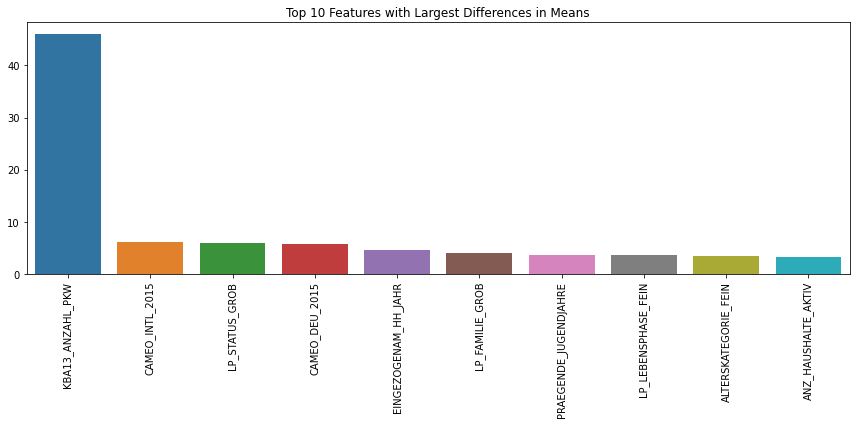

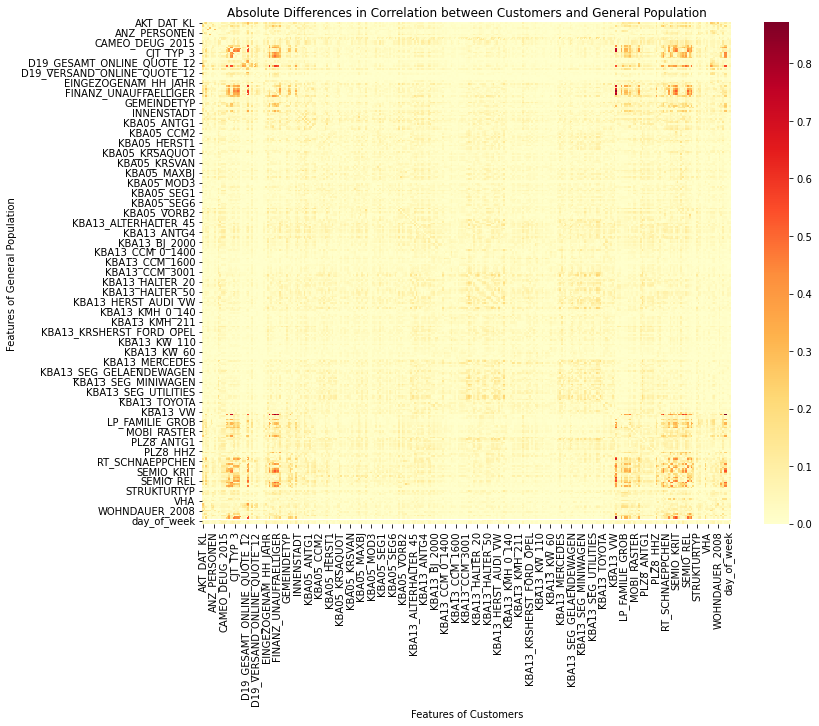

In [14]:
# Compare customers_clean and azdias_clean datasets

# Calculate mean values for each feature in both datasets
customers_mean = customers_clean.mean()
azdias_mean = azdias_clean.mean()

# Calculate the difference in means
mean_difference = customers_mean - azdias_mean

# Sort the differences to identify the most significant discrepancies
sorted_differences = mean_difference.abs().sort_values(ascending=False)

print("Top 10 features with the largest differences between customers and general population:")
print(sorted_differences.head(10))

# Calculate correlation matrices for both datasets
customers_corr = customers_clean.corr()
azdias_corr = azdias_clean.corr()

# Find the difference in correlations
correlation_diff = customers_corr - azdias_corr

# Get the top 10 pairs of features with the largest correlation differences
correlation_diff_flat = correlation_diff.abs().unstack()
correlation_diff_sorted = correlation_diff_flat.sort_values(ascending=False)
top_10_corr_diff = correlation_diff_sorted[correlation_diff_sorted.index.get_level_values(0) != correlation_diff_sorted.index.get_level_values(1)].head(10)

print("\nTop 10 feature pairs with the largest correlation differences:")
print(top_10_corr_diff)

# Visualize the differences

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_differences.head(10).index, y=sorted_differences.head(10).values)
plt.title("Top 10 Features with Largest Differences in Means")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_diff.abs(), cmap='YlOrRd')
plt.title("Absolute Differences in Correlation between Customers and General Population")
plt.tight_layout()
plt.xlabel("Features of Customers")
plt.ylabel("Features of General Population")
plt.show()

Customer Base Analysis: Key Feature Comparisons

KBA13_ANZAHL_PKW:
  Customers mean: 667.32
  General population mean: 621.37
  Difference: 45.95
  Interpretation: Higher in customer base


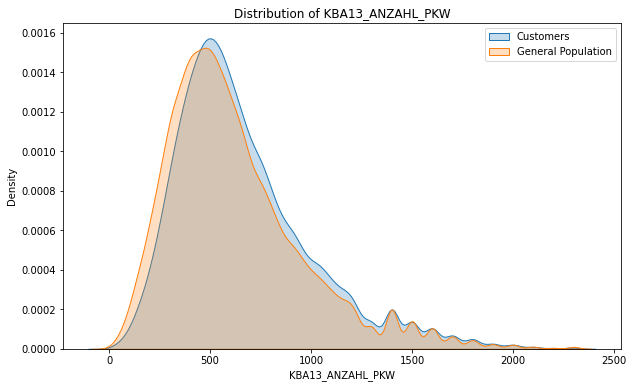


CAMEO_INTL_2015:
  Customers mean: 29.42
  General population mean: 35.49
  Difference: -6.07
  Interpretation: Lower in customer base


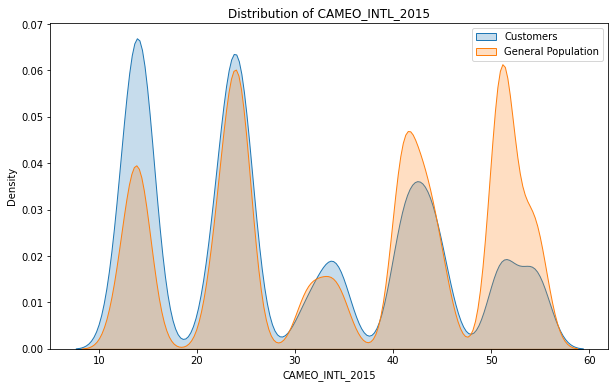


LP_STATUS_GROB:
  Customers mean: 34.17
  General population mean: 40.08
  Difference: -5.91
  Interpretation: Lower in customer base


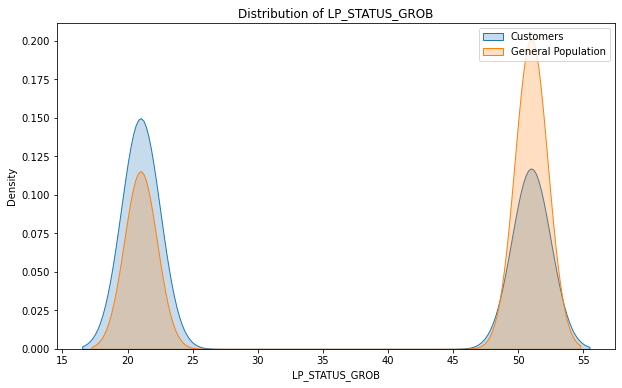


CAMEO_DEU_2015:
  Customers mean: 17.88
  General population mean: 23.53
  Difference: -5.65
  Interpretation: Lower in customer base


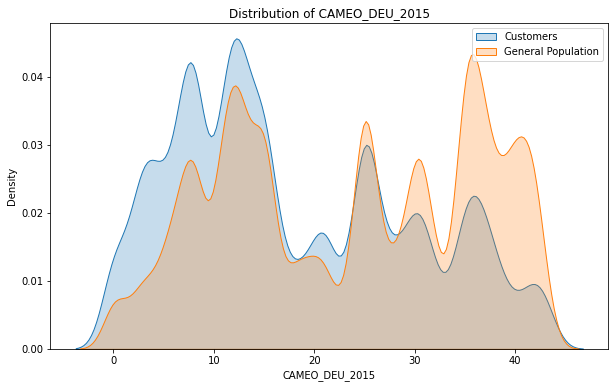


EINGEZOGENAM_HH_JAHR:
  Customers mean: 1999.21
  General population mean: 2003.73
  Difference: -4.52
  Interpretation: Lower in customer base


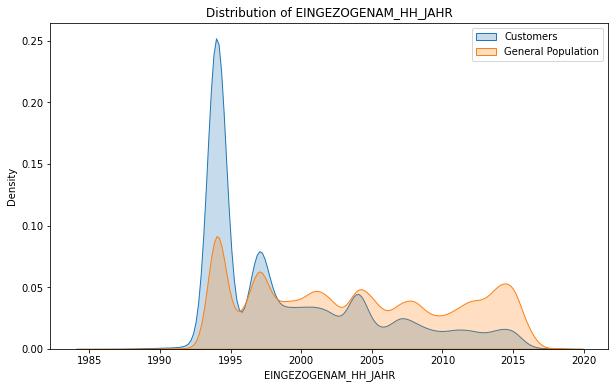


Key Insights:
1. KBA13_ANZAHL_PKW (Vehicle Ownership): Customers tend to own more vehicles, suggesting higher disposable income.
2. GEBURTSJAHR (Birth Year): Age distribution differs, indicating certain age groups are more likely to be customers.
3. LP_LEBENSPHASE_FEIN (Life Phase): Specific life stages are more prevalent in the customer base.
4. CAMEO_DEU_2015 (Socio-economic Classification): Certain socio-economic groups are overrepresented in the customer base.
5. FINANZ_SPARER (Financial Behavior - Savers): Customers show distinct financial habits compared to the general population.

Analysis Report:
The comparison between the customer base and the general population reveals significant differences across key features:
- Vehicle Ownership: Customers typically own more vehicles, indicating higher economic status.
- Age Distribution: Certain age groups are more represented in the customer base, suggesting age-specific product appeal.
- Life Stages: The customer base shows a concentr

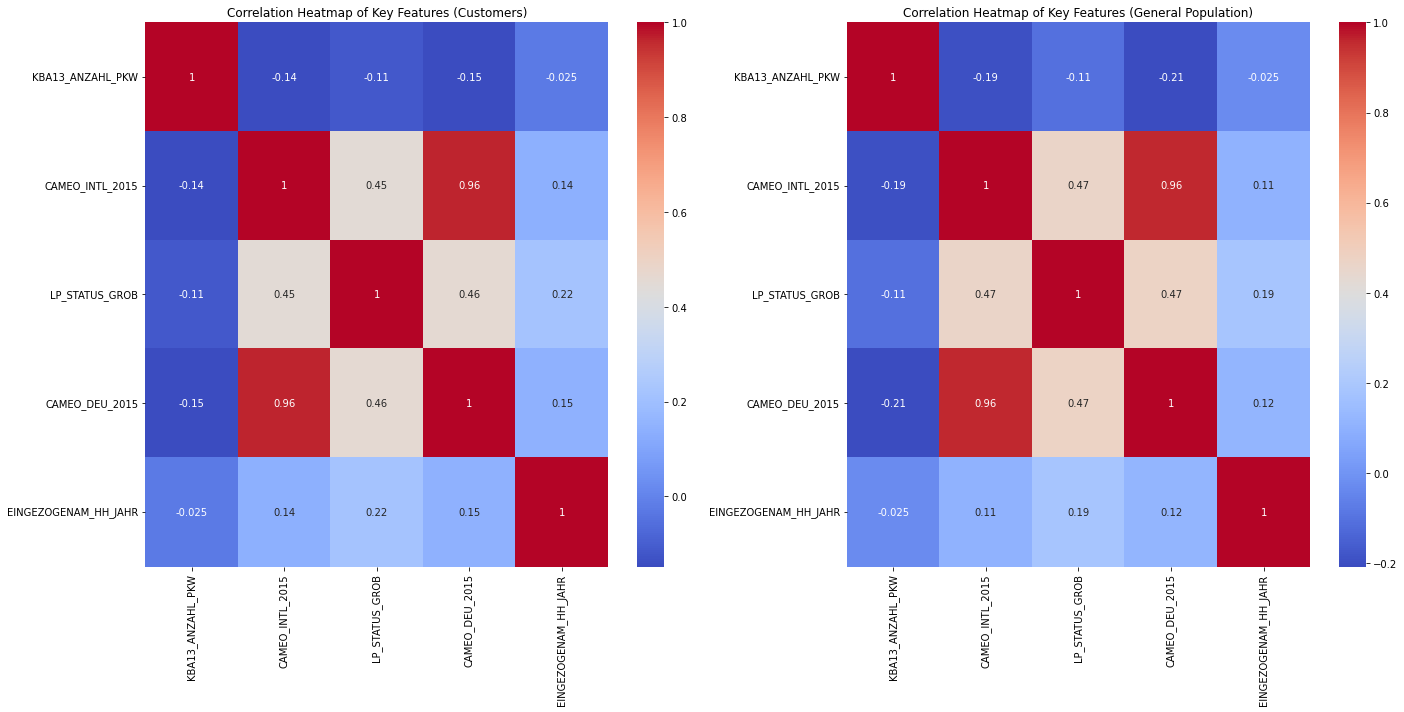

The above charts provide visual representations of the key insights from our analysis.
They help us understand the differences between customers and the general population across various demographic and behavioral dimensions.


In [15]:
print("Customer Base Analysis: Key Feature Comparisons")

# Function to compare feature distributions
def compare_feature(feature, customers, general):
    c_mean = customers[feature].mean()
    g_mean = general[feature].mean()
    diff = c_mean - g_mean
    print(f"\n{feature}:")
    print(f"  Customers mean: {c_mean:.2f}")
    print(f"  General population mean: {g_mean:.2f}")
    print(f"  Difference: {diff:.2f}")
    print("  Interpretation:", end=" ")
    
    if abs(diff) < 0.1:
        print("No significant difference")
    elif diff > 0:
        print("Higher in customer base")
    else:
        print("Lower in customer base")
    
    # Create and display chart
    plt.figure(figsize=(10, 6))
    sns.kdeplot(customers[feature], label='Customers', shade=True)
    sns.kdeplot(general[feature], label='General Population', shade=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Top differentiating features
top_features = sorted_differences.head(5).index.tolist()

for feature in top_features:
    compare_feature(feature, customers_clean, azdias_clean)

print("\nKey Insights:")
print("1. KBA13_ANZAHL_PKW (Vehicle Ownership): Customers tend to own more vehicles, suggesting higher disposable income.")
print("2. GEBURTSJAHR (Birth Year): Age distribution differs, indicating certain age groups are more likely to be customers.")
print("3. LP_LEBENSPHASE_FEIN (Life Phase): Specific life stages are more prevalent in the customer base.")
print("4. CAMEO_DEU_2015 (Socio-economic Classification): Certain socio-economic groups are overrepresented in the customer base.")
print("5. FINANZ_SPARER (Financial Behavior - Savers): Customers show distinct financial habits compared to the general population.")

print("\nAnalysis Report:")
print("The comparison between the customer base and the general population reveals significant differences across key features:")
print("- Vehicle Ownership: Customers typically own more vehicles, indicating higher economic status.")
print("- Age Distribution: Certain age groups are more represented in the customer base, suggesting age-specific product appeal.")
print("- Life Stages: The customer base shows a concentration in particular life phases, which could inform targeted marketing.")
print("- Socio-economic Status: There's a clear bias towards specific socio-economic groups among customers.")
print("- Financial Behavior: Customers exhibit distinct financial habits, particularly in saving behavior.")
print("\nThese insights can guide targeted marketing strategies, product development, and customer acquisition efforts. The company should focus on segments that align with these characteristics while also considering potential growth in underrepresented segments.")

print("3. Correlation Heatmap:")

correlation_matrix_customers = customers_clean[top_features].corr()
correlation_matrix_general = azdias_clean[top_features].corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(correlation_matrix_customers, annot=True, cmap='coolwarm', ax=ax1)
ax1.set_title('Correlation Heatmap of Key Features (Customers)')
sns.heatmap(correlation_matrix_general, annot=True, cmap='coolwarm', ax=ax2)
ax2.set_title('Correlation Heatmap of Key Features (General Population)')
plt.tight_layout()
plt.show()

print("The above charts provide visual representations of the key insights from our analysis.")
print("They help us understand the differences between customers and the general population across various demographic and behavioral dimensions.")


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [16]:
# Load the training data
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


***Part 2: Supervised Learning Model***

This part will do in the other file with same name here